###  Data Cleaning / Очистка данных
На этом этапе:
1. Удаление разреженных признаков
2. Удаление объявлений с ошибками
3. Иправление ошибок в объявлениях
4. Объедениение признаков
5. Обработка пропущенных категориальных данных
6. Обработка пропущенных числовых данных
7. Обработка выбросов

In [1]:
from random import uniform
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [22]:
conn = sqlite3.connect('db\cian.db') 


In [23]:
df = pd.read_sql_query ('''
                               SELECT *
                               FROM ad_data
                               ''', conn)

In [24]:
df.drop(columns=['link', 'description_text'], inplace=True)

In [25]:
df.shape

(89184, 36)

1. Удаление разреженных признаков

In [26]:
# удаление признаков с большим количеством пропущенных значений
df.drop(columns=['unsafe_house', 'garbage_disposal', 'elevators', 'housing_line', 'building_number', \
     'gas_supply', 'planning', 'view', 'house_class', 'floor_type', 'entrance_number', 'balcony_loggia'], inplace=True)
print(df.shape)

(89184, 24)


2. Удаление объявлений с ошибками

In [27]:
# удаление обявлений с пропущенными значениями area
df.dropna(subset=['area'], inplace=True)

In [28]:
# удаление объявления с неправдопобной ценой 9 650
df.drop(df[df.price == 9650].index, inplace=True)
print(f"Новый минимум цены: {df['price'].min()}")

Новый минимум цены: 1300000


In [29]:
# описательные статистики признака price
df['price'].describe().apply(lambda x: '%.0f' % x)

count         89181
mean       32346938
std        59597536
min         1300000
25%        11699279
50%        17077678
75%        30600000
max      7350000000
Name: price, dtype: object

In [30]:
# удалить объявления квартир, которые расположены не в Москве
districts_to_drop = ['Домодедово', 'Люберцы', 'Раменский городской округ', 'Видное', 'Балашиха', 'Реутов', 'Ленинский городской округ', 'Краснодар', 'Подольск', 'Щелково']
df = df[df.district.isin(districts_to_drop) == False]

3. Исправление ошибок в объявлениях

In [31]:
# наименьшие года постройки
df.built_year.sort_values().head(6).astype(int)

67047    1016
83843    1017
66756    1600
44455    1700
33289    1700
86545    1782
Name: built_year, dtype: int32

In [32]:
# исправление объявлений с неправдоподобным годом постройки 
df.loc[df.built_year == 1016, 'built_year'] = 2014
df.loc[df.built_year == 1017, 'built_year'] = 1917
df.loc[df.built_year == 1600, 'built_year'] = 1971
df.loc[(df.built_year == 1700) & (df.price == 11750000), 'built_year'] = 2022
df.loc[(df.built_year == 1700) & (df.price == 29900000), 'built_year'] = 2021
print(f"Новый минимум года постройки: {df['built_year'].min().astype(int)}")

Новый минимум года постройки: 1782


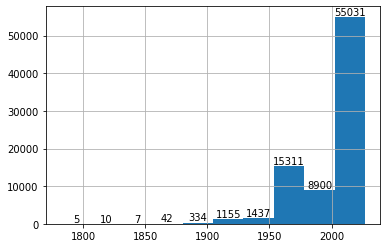

In [33]:
# гистограмма признака built_year
ax = df['built_year'].hist()
for container in ax.containers:
        ax.bar_label(container)
plt.show()

In [34]:
# замена в столбце parking null и "-" на "стихийная"
df['parking'] = df['parking'].fillna('стихийная')
df.parking.replace('-', 'стихийная', inplace=True)

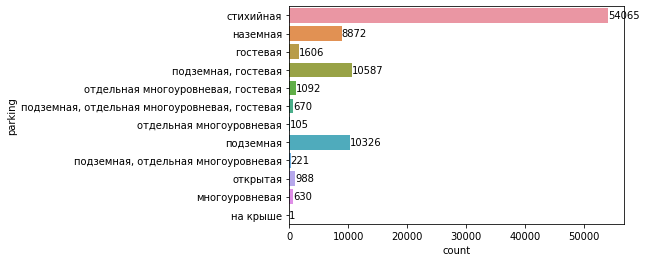

In [35]:
# распределение признака parking
ax = sns.countplot(y='parking', data=df)
for container in ax.containers:
        ax.bar_label(container)

In [36]:
# уникальные значения heating
df['heating'].unique()

array([None, 'центральное', 'котел/квартирное отопление',
       'индивидуальный тепловой пункт', 'автономная котельная', 'нет',
       'печь'], dtype=object)

In [37]:
# замена в столбце heating null и "нет" на "центральное"
df['heating'] = df['heating'].fillna('центральное')
df.heating.replace(['нет', 'печь'], 'центральное', inplace=True)

In [38]:
# уникальные значения heating
df['heating'].unique()

array(['центральное', 'котел/квартирное отопление',
       'индивидуальный тепловой пункт', 'автономная котельная'],
      dtype=object)

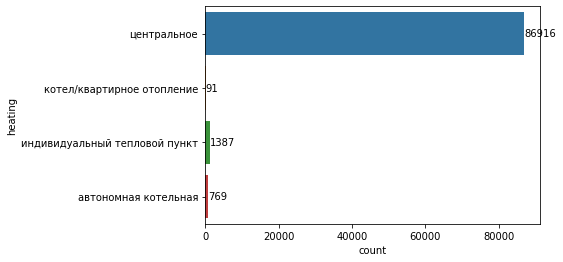

In [39]:
# распределение признака heating
ax = sns.countplot(y='heating', data=df)
for container in ax.containers:
        ax.bar_label(container)

In [40]:
# исправление столбца house_type
df.loc[(df.floors == 30) & (df.built_year == 2022) & (df.house_type == 'деревянный'), 'house_type'] = None
df.loc[(df.floors == 28) & (df.built_year == 1928) & (df.house_type == 'деревянный'), 'built_year'] = 2019
df.loc[(df.floors == 28) & (df.built_year == 2019) & (df.price == 17800000), 'house_type'] = None
df.loc[(df.price == 7800000) & (df.built_year == 2021) & (df.house_type == 'сталинский'), 'built_year'] = 1954
df.loc[(df.price == 19400000) & (df.built_year == 2014) & (df.house_type == 'сталинский'), 'house_type'] = 'монолитный'
df.loc[(df.price == 5950000) & (df.floors == 9) & (df.house_type == 'старый фонд'), 'house_type'] = 'панельный'
df.house_type.replace(['деревянный', 'сталинский', 'старый фонд'], 'кирпичный', inplace=True)
df.house_type.replace(['монолитно кирпичный', 'монолитно-кирпичный, монолитный', 'монолитно-кирпичный, монолитный, кирпичный'], 'монолитно-кирпичный', inplace=True)

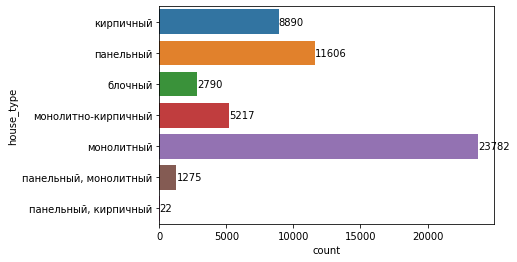

In [41]:
# распределение признака house_type
ax = sns.countplot(y='house_type', data=df)
for container in ax.containers:
        ax.bar_label(container)

In [42]:
# ранжированные уникальные значения ceiling_height
print(sorted(df['ceiling_height'].dropna().unique()))

[0.0, 1.0, 1.37, 1.6, 1.82, 1.85, 1.87, 1.9, 2.0, 2.07, 2.2, 2.23, 2.25, 2.3, 2.4, 2.42, 2.43, 2.45, 2.48, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.658, 2.66, 2.67, 2.68, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.0999999, 3.1, 3.11, 3.115, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.275, 3.28, 3.29, 3.3, 3.31, 3.32, 3.34, 3.35, 3.36, 3.37, 3.39, 3.4, 3.42, 3.43, 3.445, 3.45, 3.47, 3.5, 3.53, 3.55, 3.56, 3.57, 3.58, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.67, 3.68, 3.7, 3.74, 3.75, 3.77, 3.78, 3.8, 3.85, 3.88, 3.9, 3.91, 3.95, 3.96, 4.0, 4.03, 4.05, 4.06, 4.1, 4.12, 4.15, 4.2, 4.3, 4.35, 4.4, 4.45, 4.5, 4.55, 4.6, 4.65, 4.7, 4.8, 4.85, 4.89, 5.0, 5.05, 5.1, 5.14, 5.15, 5.2, 5.41, 5.5, 5.6, 5.7, 5.8, 6.0, 6.2,

In [43]:
# испаравление столбца ceiling_height
df['ceiling_height'] = df['ceiling_height'].fillna(0)
df['ceiling_height'] = df['ceiling_height'].transform(lambda x: round(uniform(2.4, 2.8), 2) if (x < 2.4 or 12 < x < 25) \
     else (round(x / 10, 2)) if 25 <= x <= 32.8 else (x / 100 if x == 285 else round(x, 2)))

In [44]:
# проверка испаравленного столбца ceiling_height
print(sorted(df['ceiling_height'].unique()))

[2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.34, 3.35, 3.36, 3.37, 3.39, 3.4, 3.42, 3.43, 3.44, 3.45, 3.47, 3.5, 3.53, 3.55, 3.56, 3.57, 3.58, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.67, 3.68, 3.7, 3.74, 3.75, 3.77, 3.78, 3.8, 3.85, 3.88, 3.9, 3.91, 3.95, 3.96, 4.0, 4.03, 4.05, 4.06, 4.1, 4.12, 4.15, 4.2, 4.3, 4.35, 4.4, 4.45, 4.5, 4.55, 4.6, 4.65, 4.7, 4.8, 4.85, 4.89, 5.0, 5.05, 5.1, 5.14, 5.15, 5.2, 5.41, 5.5, 5.6, 5.7, 5.8, 6.0, 6.2, 6.3, 6.35, 6.4, 6.5, 6.8, 7.0, 7.7, 8.65, 12.0]


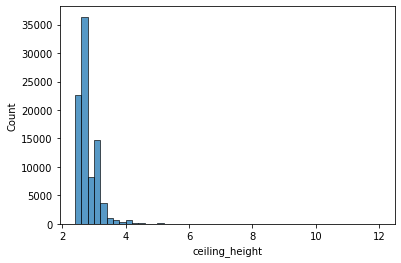

In [45]:
# гистограмма ceiling_height
ax = sns.histplot(data=df, x='ceiling_height', bins=48)

4. Объедениение признаков

In [46]:
# объединение столбцов repair и finished_shell_condition
df['interior_design'] = df['repair'].fillna(df['finished_shell_condition'])

In [47]:
df.interior_design.replace('нет', 'без ремонта', inplace=True)
df.interior_design.replace('чистовая', 'чистовой', inplace=True)
df.interior_design.replace('черновая', 'черновой', inplace=True)

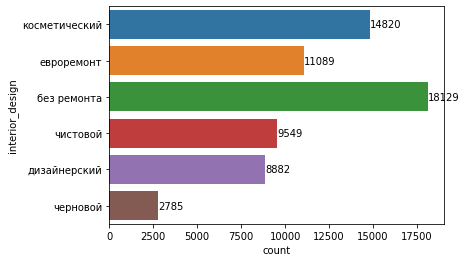

In [48]:
# распределение признака interior_design
ax = sns.countplot(y='interior_design', data=df)
for container in ax.containers:
        ax.bar_label(container)

In [49]:
# удаление ненужных столбцов repair и finished_shell_condition
df.drop(columns=['repair', 'finished_shell_condition'], inplace=True)

In [50]:
# процент пропущеннных значений нового признака interior_design
print(f"Признак interior_design содержит {df['interior_design'].isna().mean().round(5) * 100}% пропущенных значений")

Признак interior_design содержит 26.815% пропущенных значений


5. Обработка выбросов

In [51]:
# 10 наименьших значений living_area
df['living_area'].sort_values().head(10)

30802    0.5
45779    1.0
30918    1.0
64429    1.0
68223    1.0
86681    1.0
27771    1.2
33526    1.5
28600    1.5
28271    1.6
Name: living_area, dtype: float64

In [52]:
# минимальная норма жилой площади составляет 6 кв. м
df = df.drop(df[(df.living_area < 6) & (df.living_area is not None)].index)
len(df)

89093

<AxesSubplot:xlabel='living_area'>

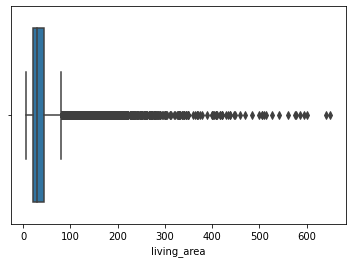

In [53]:
# коробчатая диаграмма living_area
sns.boxplot(x = 'living_area', data=df)

6. Обработка пропущенных категориальных данных

In [54]:
# процент пропущенных значений для категориальных данных
ds_missing = df.select_dtypes(include=['object']).isna().mean().round(5) * 100
ds_missing.sort_values(ascending=False)

house_type         39.917
bathroom           30.256
interior_design    26.812
housing_type       14.174
sale_type           8.721
metro_station       4.136
flat_type           0.000
address             0.000
district            0.000
seller              0.000
parking             0.000
heating             0.000
dtype: float64

In [55]:
# замена пропущенных наблюдений на значение "пропущено"
for column in df.select_dtypes(include=['object']).columns.tolist():
    df[column] = df[column].fillna('пропущено')

In [56]:
# процент пропущенных значений для категориальных данных после замены
ds_missing = df.select_dtypes(include=['object']).isna().mean().round(5) * 100
ds_missing.sort_values(ascending=False)

flat_type          0.0
sale_type          0.0
address            0.0
district           0.0
metro_station      0.0
seller             0.0
housing_type       0.0
bathroom           0.0
house_type         0.0
parking            0.0
heating            0.0
interior_design    0.0
dtype: float64

7. Обработка пропущенных числовых данных

In [57]:
# процент пропущенных значений для числовых данных
ds_missing = df.select_dtypes(exclude=['object']).isna().mean().round(5) * 100
ds_missing.sort_values(ascending=False)

living_area       23.075
kitchen_area      18.249
built_year         7.763
rooms              0.000
price              0.000
mortgage           0.000
area               0.000
floor              0.000
floors             0.000
ceiling_height     0.000
is_suspicious      0.000
dtype: float64

Импутация пропущенных значений признака living_area

In [58]:
df_before_imputation  = df.copy()

In [59]:
# импутация пропущенных значений признака living_area с помощью линейной регрессии
linreg = LinearRegression()
data = df[['area','price','rooms','living_area']]
x_train = data[data['living_area'].notnull()].drop(columns='living_area')
y_train = data[data['living_area'].notnull()]['living_area']
x_test = data[data['living_area'].isnull()].drop(columns='living_area')
y_test = data[data['living_area'].isnull()]['living_area']
linreg.fit(x_train, y_train)
predicted = linreg.predict(x_test)
df.loc[df.living_area.isnull(), 'living_area'] = predicted
print(f"coefficient of determination: {linreg.score(x_train, y_train)}")
print(f"intercept: {linreg.intercept_}")
print(f"slope: {linreg.coef_}")

coefficient of determination: 0.8724723250968817
intercept: -5.004603090495813
slope: [ 6.43514518e-01 -3.74273519e-08  3.03703901e-01]


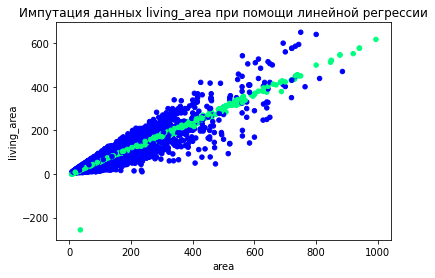

In [60]:
# точечная диаграмма признака living_area после импутации данных
fig = plt.Figure()
null_values = df_before_imputation['living_area'].isnull()
fig = df.plot(x='area', y='living_area', kind='scatter', c=null_values, title='Импутация данных living_area при помощи линейной регрессии', cmap='winter', colorbar=False)

In [61]:
# удаление точек данных, значение living_area которых меньше нормы 6 кв. м
df = df.drop(df[df.living_area < 6].index)
print(f"Количество наблюдений до удаления: {len(df_before_imputation)}, количество наблюдений после удаления: {len(df)}")

Количество наблюдений до удаления: 89093, количество наблюдений после удаления: 88610


count    88610.0
mean        39.5
std         33.4
min          6.0
25%         20.0
50%         31.4
75%         46.0
max        650.0
Name: living_area, dtype: float64


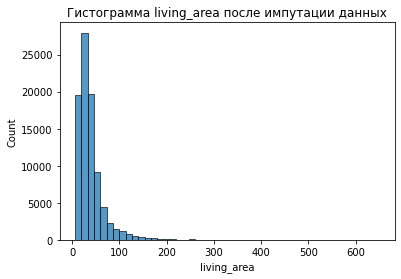

In [62]:
# описательные статистики и гистограмма living_area
print(df['living_area'].describe().round(1))
ax = sns.histplot(data=df, x='living_area', bins=48).set(title='Гистограмма living_area после импутации данных')

Импутация пропущенных значений признака kitchen_area

In [63]:
# обработка пропущенных значнений kitchen_area
df_before_imputation_kitchen_area  = df.copy()

In [64]:
# импутация пропущенных значений признака living_area с помощью линейной регрессии
linreg = LinearRegression()
data = df[['area','price','kitchen_area']]
x_train = data[data['kitchen_area'].notnull()].drop(columns='kitchen_area')
y_train = data[data['kitchen_area'].notnull()]['kitchen_area']
x_test = data[data['kitchen_area'].isnull()].drop(columns='kitchen_area')
y_test = data[data['kitchen_area'].isnull()]['kitchen_area']
linreg.fit(x_train, y_train)
predicted = linreg.predict(x_test)
df.loc[df.kitchen_area.isnull(), 'kitchen_area'] = predicted
print(f"coefficient of determination: {linreg.score(x_train, y_train)}")
print(f"intercept: {linreg.intercept_}")
print(f"slope: {linreg.coef_}")

coefficient of determination: 0.2823575257144195
intercept: 7.150066504982234
slope: [7.40618770e-02 1.58750365e-08]


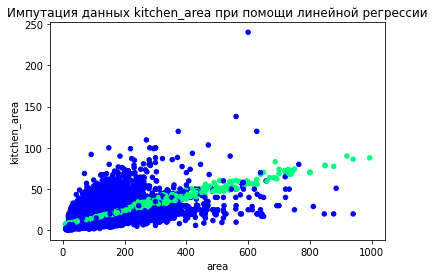

In [65]:
# точеченая диаграмма признака living_area после импутации данных
fig = plt.Figure()
null_values = df_before_imputation_kitchen_area['kitchen_area'].isnull()
fig = df.plot(x='area', y='kitchen_area', kind='scatter', c=null_values, title='Импутация данных kitchen_area при помощи линейной регрессии', cmap='winter', colorbar=False)

count    88610.0
mean        12.9
std          7.3
min          0.6
25%          8.4
50%         11.0
75%         15.9
max        240.0
Name: kitchen_area, dtype: float64


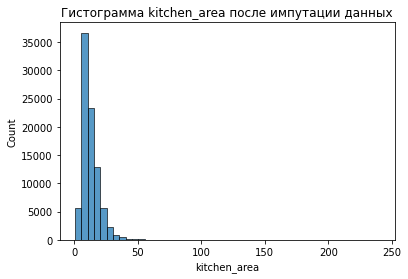

In [66]:
# описательные статистики и гистограмма living_area
print(df['kitchen_area'].describe().round(1))
ax = sns.histplot(data=df, x='kitchen_area', bins=48).set(title='Гистограмма kitchen_area после импутации данных')

In [67]:
# процент пропущенных значений для числовых данных
ds_missing = df.select_dtypes(exclude=['object']).isna().mean().round(5) * 100
ds_missing.sort_values(ascending=False)

built_year        7.622
rooms             0.000
price             0.000
mortgage          0.000
area              0.000
living_area       0.000
kitchen_area      0.000
floor             0.000
floors            0.000
ceiling_height    0.000
is_suspicious     0.000
dtype: float64

Импутация пропущенных значений признака built_year (новостройки)

In [68]:
# стандартные отклонения built_year для различных housing_type
df.groupby('housing_type')['built_year'].std().round(1)

housing_type
вторичное      27.9
новостройка     1.6
пропущено      27.5
Name: built_year, dtype: float64

Так как год постройки для новостроек характеризуется малой степенью разброса, пропущенные значения built_year можно заменить средним.

In [69]:
df_newbuilt_year_mean = df.copy()

In [70]:
# процент пропущенных данных built_year перед импутацией
df_newbuilt_year_mean['built_year'].isna().mean().round(5) * 100

7.622

In [71]:
# импутация пропущенных значений built_year средним для новостроек
mean_imputer = SimpleImputer(strategy='mean')
df.loc[df.housing_type == 'новостройка', 'built_year'] = mean_imputer.fit_transform(df.loc[df.housing_type == 'новостройка', 'built_year'].values.reshape(-1,1))

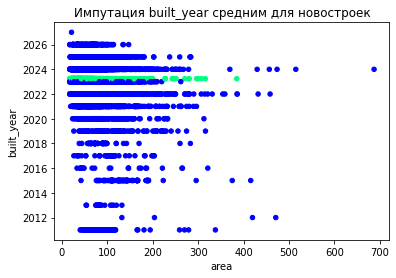

In [72]:
# точечная диаграмма импутации данных built_year
fig = plt.Figure()
null_values = df_newbuilt_year_mean.loc[df_newbuilt_year_mean.housing_type == 'новостройка', 'built_year'].isnull()
fig = df.loc[df.housing_type == 'новостройка'].plot(x='area', y='built_year', kind='scatter', c=null_values, cmap='winter', title='Импутация built_year средним для новостроек', colorbar=False)


In [73]:
# процент пропущенных данных built_year после импутации
df_newbuilt_year_mean['built_year'].isna().mean().round(5) * 100


7.622

Обработка пропущенных значений признака built_year (вторичное жилье)

In [74]:
print(f"{df.loc[df.housing_type == 'вторичное', 'built_year'].isna().sum()} пропущенных значений built_year для вторичного жилья")
print(f"{df.loc[df.housing_type == 'пропущено', 'built_year'].isna().sum()} пропущенных значений built_year без указанного housing_type")

2625 пропущенных значений built_year для вторичного жилья
2328 пропущенных значений built_year без указанного housing_type


Так как год постройки для вторичного жилья и объявлений без указанного housing_type характеризуется большой степенью разброса, пропущенные значения built_year нельзя заменить средним. Эти точки нужно удалить.

In [75]:
# удаление обявлений с оставшимися пропущенными значениями built_year
df.dropna(subset=['built_year'], inplace=True)

In [76]:
df.shape

(83657, 23)

In [77]:
# проверка обработки пропущенных значений для числовых данных
ds_missing = df.select_dtypes(exclude=['object']).isna().mean().round(5) * 100
ds_missing.sort_values(ascending=False)

rooms             0.0
price             0.0
mortgage          0.0
area              0.0
living_area       0.0
kitchen_area      0.0
floor             0.0
floors            0.0
built_year        0.0
ceiling_height    0.0
is_suspicious     0.0
dtype: float64

In [78]:
# сохрание очищенных данных
df.to_sql('ad_data_cleaned', conn, if_exists='replace', index = False)

83657

ИТОГ:
Новый минимум цены (price) - 1 300 000, года постройки (built_year) - 1782.

Количество уникальных значений parking сократилось с 13 до 12, heating - с 7 до 4, house_type - с 14 до 8

Пропущенные данные отсутсвуют.

Размерность датафрейма до очистки данных - (89184, 36), после - (81856, 23).